In [1]:
from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
import tensorflow as tf
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import keras
import ast
from glob import glob
from dask import bag
import os
from keras import Model, Sequential, optimizers
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
from io import BytesIO
%matplotlib inline

Using TensorFlow backend.


In [2]:
from random import shuffle
fnames = glob('input/train_simplified/*.csv')
shuffle(fnames)
fnames = fnames[0:5]
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
drawlist = []
for f in fnames[0:10]:
    first = pd.read_csv(f, nrows=10) # make sure we get a recognized drawing
    first = first[first.recognized==True].head(2)
    drawlist.append(first)
draw_df = pd.DataFrame(np.concatenate(drawlist), columns=cnames)
draw_df

,countrycode,drawing,key_id,recognized,timestamp,word
0,TW,"[[[97, 79, 44, 30, 23, 21, 25, 34, 53, 78, 109...",4952882308710400,True,2017-01-29 13:23:51.786560,mouse
1,BR,"[[[16, 4, 0, 15, 30, 56, 63, 103, 153, 199, 21...",5464784088596480,True,2017-03-06 19:17:22.518130,mouse
2,BG,"[[[57, 97, 128, 151, 159], [0, 43, 86, 136, 17...",5490708884488192,True,2017-01-18 11:51:51.193520,knee
3,CA,"[[[28, 7, 1, 2, 15], [1, 40, 66, 95, 127]], [[...",5987975680753664,True,2017-03-26 17:46:08.742390,knee
4,CZ,"[[[67, 69, 74, 94, 105, 116, 119, 115, 120, 13...",4599994839465984,True,2017-03-05 10:52:22.314850,octopus
5,CH,"[[[99, 84, 80], [3, 25, 56]], [[93, 103, 116, ...",6746256573464576,True,2017-01-23 21:23:00.117470,octopus
6,CH,"[[[59, 44, 28, 17, 8, 0, 0, 13, 32, 49, 85, 11...",5152530285723648,True,2017-03-19 15:52:39.229000,face
7,US,"[[[105, 90, 80, 37, 27, 14, 3, 0, 7, 14, 38, 5...",6485643624448000,True,2017-03-03 06:07:03.300680,face
8,RU,"[[[0, 10, 45, 118, 139, 159, 205, 221, 226, 22...",4545746600722432,True,2017-03-27 02:34:59.591150,crocodile
9,US,"[[[78, 71, 26, 0, 84], [12, 11, 22, 23, 32]], ...",5578314905288704,True,2017-03-09 02:41:27.457940,crocodile


In [3]:
evens = range(0,24,2)
odds = range(1,23, 2)
df1 = draw_df[draw_df.index.isin(evens)]
df2 = draw_df[draw_df.index.isin(odds)]

example1s = [ast.literal_eval(pts) for pts in df1.drawing.values]
example2s = [ast.literal_eval(pts) for pts in df2.drawing.values]

example1s
example2s

[[[[16, 4, 0, 15, 30, 56, 63, 103, 153, 199, 218, 234, 250, 255, 255, 243],
   [93, 74, 33, 4, 0, 10, 75, 68, 68, 76, 16, 21, 31, 49, 72, 91]],
  [[243, 243], [91, 91]]],
 [[[28, 7, 1, 2, 15], [1, 40, 66, 95, 127]],
  [[140, 133, 103, 100, 105], [0, 5, 72, 114, 139]],
  [[23, 25, 29, 44, 110, 145], [138, 224, 232, 238, 239, 255]],
  [[115, 132, 149, 180], [148, 188, 217, 233]]],
 [[[99, 84, 80], [3, 25, 56]],
  [[93, 103, 116, 123, 128, 129, 120], [9, 3, 0, 10, 22, 41, 65]],
  [[81, 130], [58, 60]],
  [[121, 157], [61, 104]],
  [[108, 105, 95, 88], [57, 85, 114, 123]],
  [[79, 66, 26, 16, 0], [56, 77, 128, 137, 146]],
  [[84, 37, 23, 15, 12], [59, 155, 177, 182, 180]],
  [[117, 111, 111, 121, 131, 144, 159, 172, 184],
   [62, 77, 98, 132, 149, 163, 170, 169, 157]],
  [[128, 146, 191, 216, 234, 249, 255], [71, 96, 124, 133, 135, 132, 126]],
  [[103, 102, 85, 73, 64], [67, 87, 158, 182, 190]]],
 [[[105,
    90,
    80,
    37,
    27,
    14,
    3,
    0,
    7,
    14,
    38,
    57,


C:\Users\Abir Hassan\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


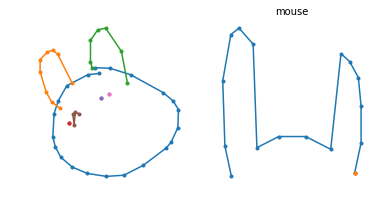

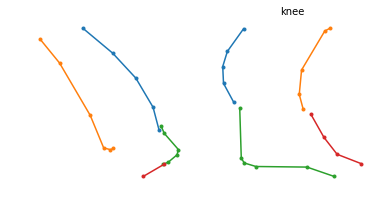

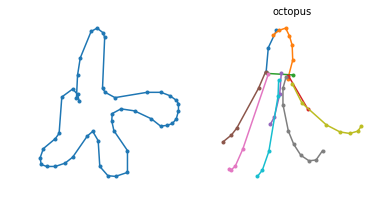

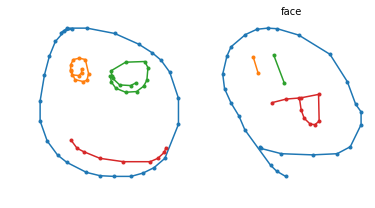

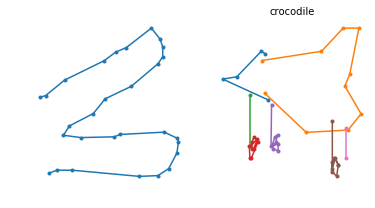

In [4]:
labels = df2.word.tolist()
for i, example in enumerate(example1s):
    plt.figure(figsize=(6,3))
    for x,y in example:
        plt.subplot(1,2,1)
        plt.plot(x, y, marker='.')
        plt.axis('off')
    plt.gca().invert_yaxis()
    for x,y, in example2s[i]:
        plt.subplot(1,2,2)
        plt.plot(x, y, marker='.')
        plt.axis('off')
        label = labels[i]
        plt.title(label, fontsize=10)
    plt.gca().invert_yaxis()
    plt.show()

In [5]:
#%% set global vars and params
class_files = fnames
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(class_files)}

class_fraction = 1                     ## 
imheight, imwidth = 32, 32  
ims_per_class = 2000 

num_classes = int(len(class_files)*class_fraction)
num_classes 

5

In [6]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = fnames
for i,c in enumerate(class_paths[0: num_classes]):
    train = pd.read_csv(c, usecols=['drawing', 'recognized'], nrows=ims_per_class*5//4)
    train = train[train.recognized == True].head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

In [7]:
train_grand.shape

(10000, 1025)

In [8]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)


(9000, 5) 
 (9000, 32, 32, 1) 
 (1000, 5) 
 (1000, 32, 32, 1)


In [9]:
#input_shape = X_tr[0].shape

# Modify model layers to increase accuracy
# ------------------------------------------------
# Model 1
# ------------------------------------------------

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 680)               2785960   
__________

In [10]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.val_acc = []
        self.acc = []
        
    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        
    def on_epoch_end(self, epoch, logs):
        self.val_acc.append(logs.get('val_acc'))
        self.acc.append(logs.get('acc'))

history_cb = LossHistory()
callbacks = [history_cb]

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

In [12]:
tf.global_variables_initializer()
model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Train on 9000 samples, validate on 1000 samples
Epoch 1/22
9000/9000 [==============================] - 33s 4ms/step - loss: 0.6598 - acc: 0.7510 - top_3_accuracy: 0.9599 - val_loss: 0.3766 - val_acc: 0.8430 - val_top_3_accuracy: 0.9950
Epoch 2/22
9000/9000 [==============================] - 33s 4ms/step - loss: 0.3657 - acc: 0.8644 - top_3_accuracy: 0.9928 - val_loss: 0.3080 - val_acc: 0.8740 - val_top_3_accuracy: 0.9980
Epoch 3/22
9000/9000 [==============================] - 32s 4ms/step - loss: 0.2874 - acc: 0.8922 - top_3_accuracy: 0.9948 - val_loss: 0.2687 - val_acc: 0.9040 - val_top_3_accuracy: 0.9980
Epoch 4/22
9000/9000 [==============================] - 33s 4ms/step - loss: 0.2396 - acc: 0.9119 - top_3_accuracy: 0.9966 - val_loss: 0.2694 - val_acc: 0.9050 - val_top_3_accuracy: 0.9970
Epoch 5/22
9000/9000 [==============================] - 33s 4ms/step - loss: 0.1930 - acc: 0.9309 - top_3_accuracy: 0.9976 - val_loss: 0.2580 - val_acc: 0.8990 - val_top_3_accuracy: 0.9970
Epoch 6

In [13]:
model.save('test1')

In [14]:
keras.metrics.top_3_accuracy = top_3_accuracy
model = keras.models.load_model('test1', custom_objects= {'metrics':['accuracy', top_3_accuracy]})

In [16]:
mode21Hist = history_cb
print(len(mode21Hist.acc))
print(len(mode21Hist.val_acc))


22
22


Text(0, 0.5, 'Accuracy')

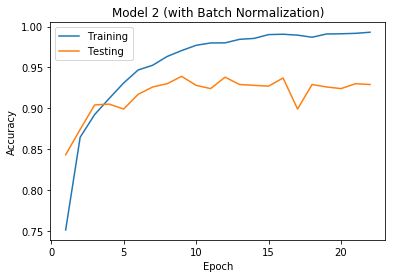

In [18]:
xVal = np.arange(1, 23, 1)
plt.plot(xVal, mode21Hist.acc)
plt.plot(xVal, mode21Hist.val_acc)
plt.title('Model 2 (with Batch Normalization)')
plt.legend(("Training", "Testing"), loc="best")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [23]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(2000, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(500, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_12 (Batc (None, 26, 26, 64)        256       
__________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])
tf.global_variables_initializer()
model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Train on 9000 samples, validate on 1000 samples
Epoch 1/22
9000/9000 [==============================] - 280s 31ms/step - loss: 0.6454 - acc: 0.7647 - top_3_accuracy: 0.9774 - val_loss: 1.3498 - val_acc: 0.7120 - val_top_3_accuracy: 0.9520
Epoch 2/22
9000/9000 [==============================] - 275s 31ms/step - loss: 0.3855 - acc: 0.8651 - top_3_accuracy: 0.9921 - val_loss: 5.6114 - val_acc: 0.3770 - val_top_3_accuracy: 0.6880
Epoch 3/22
9000/9000 [==============================] - 280s 31ms/step - loss: 0.2786 - acc: 0.9021 - top_3_accuracy: 0.9944 - val_loss: 0.4355 - val_acc: 0.8620 - val_top_3_accuracy: 0.9930
Epoch 4/22
 448/9000 [>.............................] - ETA: 4:22 - loss: 0.2284 - acc: 0.9330 - top_3_accuracy: 1.0000

In [ ]:
model.save('test2')
keras.metrics.top_3_accuracy = top_3_accuracy
model = keras.models.load_model('test2', custom_objects= {'metrics':['accuracy', top_3_accuracy]})
